# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [ ]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [ ]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


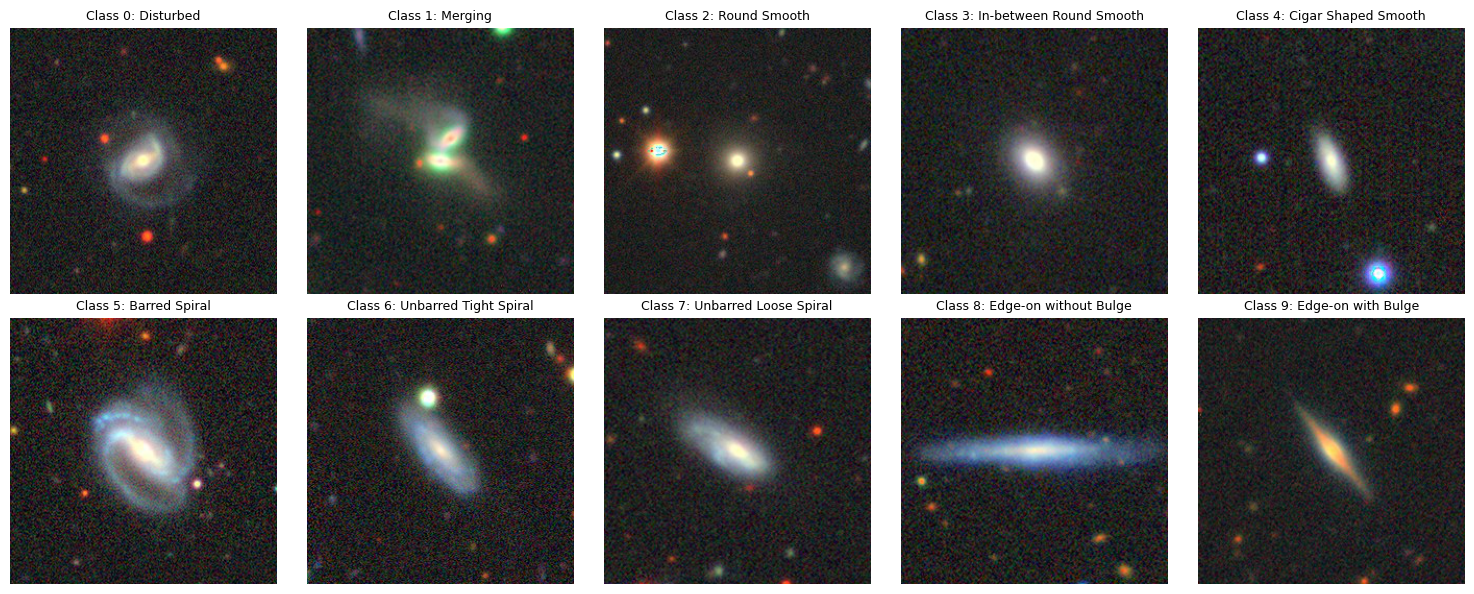

In [ ]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [ ]:
<YOUR_CODE>

# Evaluation

In [ ]:
preds = # <Your preidctions here for TEST>
true_test_labels = galaxy_dataset['test']['label']
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)